# 2D Gaussians problem setting

Visualizing the difference between unsupervised and semi-supervised subspace alignment.

In [31]:
import numpy as np
import numpy.random as rnd
import scipy.stats as st
import scipy.linalg as alg

In [32]:
import sys
sys.path.append("..")
from subalign import SubspaceAlignedClassifier, SemiSubspaceAlignedClassifier

In [33]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set(style="whitegrid")

fS = 24
figS2 = (10,5)
figS3 = (20,5)
font = {'weight' : 'bold', 'size'   : fS}
matplotlib.rc('font', **font)

clrs = ['r', 'b']

In [34]:
'''Generate data'''

# Dimensionality
D = 2

# Subspace dim
d = 2

# Number of classes
K = 2

# Sample sizes
N = 40
N0 = 20
N1 = N - N0
M = 20
M0 = 10
M1 = M - M0

# Number of target labels
Mu = 3

muS0 = np.array([-2, -1])
muS1 = np.array([2, 1])
muT0 = np.array([0, 3])
muT1 = np.array([-1, 0])
SiS0 = np.array([[6, 0.9],[0.9, 1]])
SiS1 = np.array([[6, 0.9],[0.9, 1]])
SiT0 = np.array([[1, 0],[0, 1]])
SiT1 = np.array([[1, 0],[0, 1]])

pS0 = st.multivariate_normal(muS0, SiS0)
pS1 = st.multivariate_normal(muS1, SiS1)
pT0 = st.multivariate_normal(muT0, SiT0)
pT1 = st.multivariate_normal(muT1, SiT1)

X = np.concatenate((pS0.rvs(N0), pS1.rvs(N1)), axis=0)
Y = np.concatenate((np.zeros((N0,)), np.ones(N1,)), axis=0)

Z = np.concatenate((pT0.rvs(M0), pT1.rvs(M1)), axis=0)
U = np.concatenate((np.zeros((M0,)), np.ones(M1,)), axis=0)
    
# Z-score data
X = st.zscore(X)
Z = st.zscore(Z)

In [35]:
'''Select target samples to be labeled'''

u = np.zeros((K*Mu, 2), dtype='uint8')
u_ = np.zeros((M, K), dtype='bool')

for k in range(K):

    # Subsample
    ix = rnd.choice(np.arange(M), size=Mu, p=(U==k)/np.sum(U==0))
    
    # Index array
    u[k*Mu:(k+1)*Mu, 0] = ix
    u[k*Mu:(k+1)*Mu, 1] = k
    
    # Boolean version
    u_[ix, k] = True
                

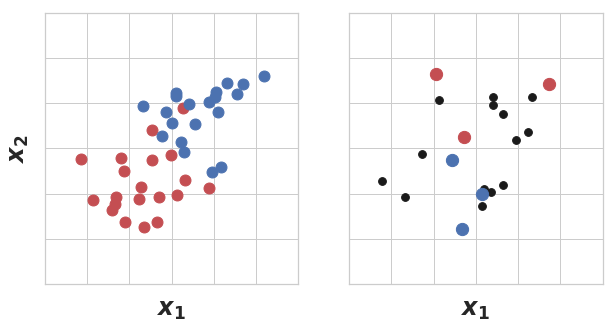

In [36]:
'''Visualize problem setting'''

fig = plt.figure(figsize=figS2)        
    
ax0 = fig.add_subplot(121)

ax0.set_xlim([-3,3])
ax0.set_ylim([-3,3])

ax0.scatter(X[Y == 0, 0], X[Y == 0, 1], c='r', s=120)
ax0.scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', s=120)
ax0.set_xlabel('$x_1$', fontsize=fS)
ax0.set_ylabel('$x_2$', fontsize=fS)

ax1 = fig.add_subplot(122, sharex=ax0, sharey=ax0)
ax1.scatter(Z[:, 0], Z[:, 1], c='k', s=60)
for k in range(K):
    ax1.scatter(Z[u_[:,k], 0], Z[u_[:,k], 1], c=clrs[k], s=150)
ax1.set_xlabel('$x_1$', fontsize=fS)
ax1.set_xticklabels(labels='')
ax1.set_yticklabels(labels='')
    
fig.savefig('viz/2DG_problem-setting.png', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_problem-setting.eps', bbox_inches='tight', padding=None)

In [37]:
'''Find principal components'''

# Domain means
muX = np.mean(X, axis=0)[:, np.newaxis].T
muZ = np.mean(Z, axis=0)[:, np.newaxis].T

# Centered data
X_ = X - muX
Z_ = Z - muZ

# Estimate principal components manually
aX, CX = alg.eig(np.cov(X_.T))
aZ, CZ = alg.eig(np.cov(Z_.T))

# Sort components on decreasing eigenvalues
ixX = np.argsort(aX)[::-1]
CX = CX[ixX,:]
ixZ = np.argsort(aZ)[::-1]
CZ = CZ[ixZ,:]

In [38]:
'''Process target data'''

# Map target data onto total target components
ZC = Z @ CZ

In [39]:
'''Unsupervised alignment'''

# Optimal linear transformation matrix
W = CX.T @ CZ

# Map source data onto source principal components and align to target components
XW = X @ CX @ W

In [40]:
'''Semi-supervised alignment'''

# Call instance of subalign
clf = SemiSubspaceAlignedClassifier()

# Obtain transformation matrix and components
V, CX, CZ = clf.semi_subspace_alignment(X, Y, Z, u, subspace_dim=d)

XC = np.zeros((N, d))
XV = np.zeros((N, d))

# Align each class
for k in range(K):
    
    # Class means
    muXk = np.mean(X[Y == k, :], axis=0)
    muZk = np.mean(ZC[u_[:,k], :], axis=0, keepdims=1)
    
    # Map source data onto source principal components and align to target components
    XV[Y == k, :] = (X[Y == k, :] - muXk) @ CX[k] @ V[k] + muZk

Final regularization parameter = 1e-06
Final regularization parameter = 1e-06
Final regularization parameter = 1e-06
Final regularization parameter = 1e-06
Final regularization parameter = 1e-06


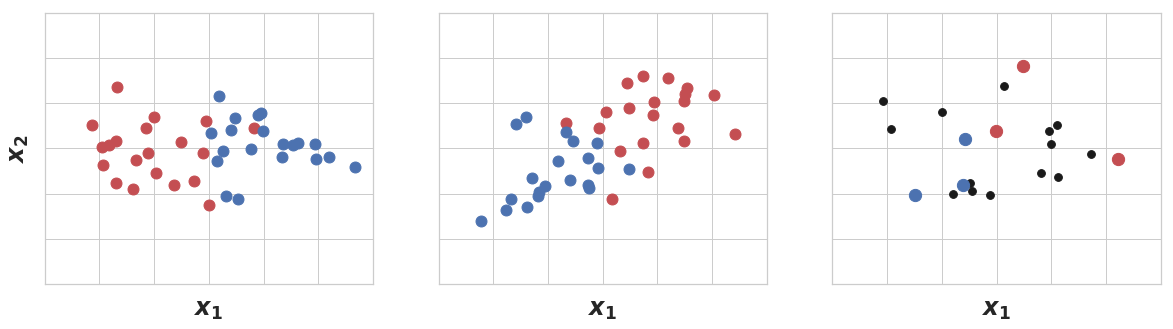

In [41]:
'''Visualize data'''

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=figS3)

ax[0].set_xlim([-3,3])
ax[0].set_ylim([-3,3])

XV0 = XV[Y == 0, :]
XV1 = XV[Y == 1, :]

# Plot unsupervised alignment
ax[0].scatter(XW[Y == 0, 0], XW[Y == 0, 1], c='r', s=120)
ax[0].scatter(XW[Y == 1, 0], XW[Y == 1, 1], c='b', s=120)
ax[0].set_xlabel('$x_1$', fontsize=fS)
ax[0].set_ylabel('$x_2$', fontsize=fS)
ax[0].set_xticklabels(labels='')
ax[0].set_yticklabels(labels='')

# Plot semi-supervised alignment
ax[1].scatter(XV0[:, 0], XV0[:, 1], c='r', s=120)
ax[1].scatter(XV1[:, 0], XV1[:, 1], c='b', s=120)
ax[1].set_xlabel('$x_1$', fontsize=fS)
ax[1].set_xticklabels(labels='')
ax[1].set_yticklabels(labels='')

# Plot target data
ax[2].scatter(ZC[:, 0], ZC[:, 1], c='k', s=60)
for k in range(K):
    ax[2].scatter(ZC[u_[:,k], 0], ZC[u_[:,k], 1], c=clrs[k], s=150)
ax[2].set_xlabel('$x_1$', fontsize=fS)
ax[2].set_xticklabels(labels='')
ax[2].set_yticklabels(labels='')

fig.savefig('viz/2DG_subalign.png', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_subalign.eps', bbox_inches='tight', padding=None)